# Uncertainty Quantification on Glioblastoma Image Segmentation

## Imports

In [ ]:
from google.colab import drive
import nibabel as nib
from matplotlib import pyplot as plt
import os
import shutil
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Normalize, Resize, ToTensor, Compose
from torchvision import transforms
import nibabel as nib
from tqdm import tqdm
import glob
from PIL import Image
import random
from scipy.spatial.distance import directed_hausdorff
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler

## Data Acquisition

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/datasets/brats2018.zip

Archive:  /content/drive/MyDrive/datasets/brats2018.zip
replace MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
train_folder = '/content/MICCAI_BraTS_2018_Data_Training/'
val_folder = '/content/MICCAI_BraTS_2018_Data_Validation/'
flair = 'flair.nii'
t1 = 't1.nii'
t1ce = 't1ce.nii'
t2 = 't2.nii'
seg = 'seg.nii'
images = [flair, t1, t1ce, t2, seg]

In [ ]:
def count_folders(folder_path):
  count = 0
  for patient_folder in os.listdir(folder_path):
      count +=1
  return count

In [ ]:
hgg_train_count_hgg = count_folders(train_folder + 'HGG')
lgg_train_count_lgg = count_folders(train_folder + 'LGG')

print('HGG count is: ' + str(hgg_train_count_hgg))
print('LGG count is: ' + str(lgg_train_count_lgg))
print('Total count is: ' + str(hgg_train_count_hgg + lgg_train_count_lgg))

HGG count is: 210
LGG count is: 75
Total count is: 285


### Example of images

flair.nii
(240, 240, 155)


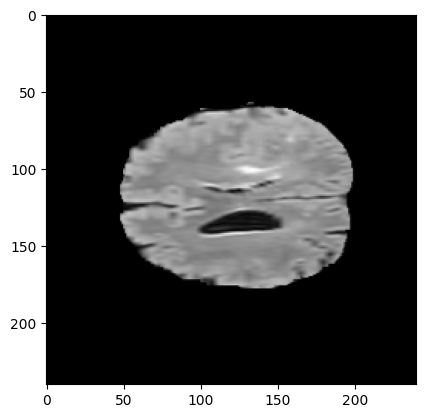

t1.nii
(240, 240, 155)


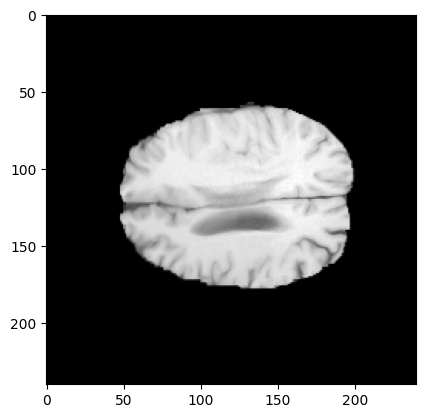

t1ce.nii
(240, 240, 155)


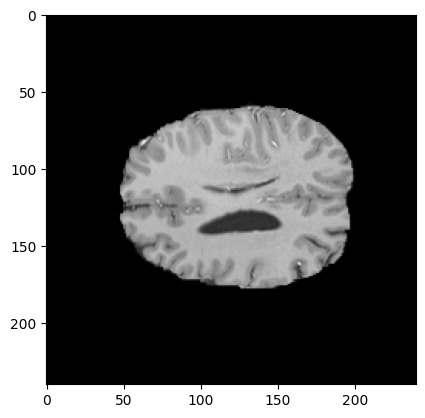

t2.nii
(240, 240, 155)


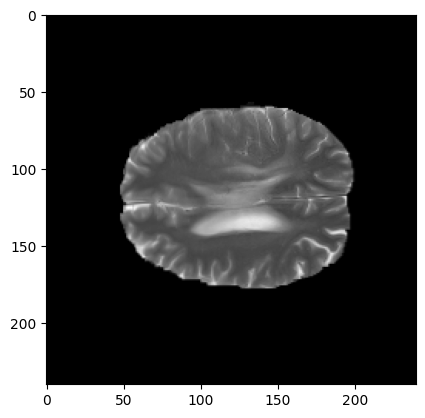

seg.nii
(240, 240, 155)


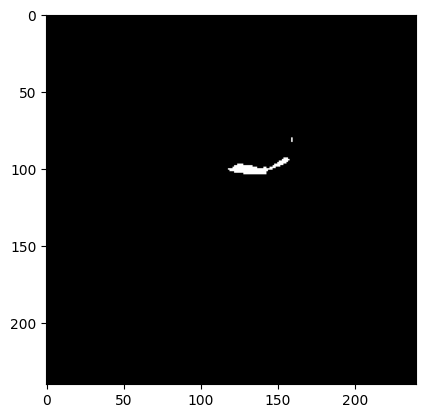

In [ ]:
for i in range(5):
  example_image = nib.load(train_folder + "HGG/Brats18_2013_10_1/Brats18_2013_10_1_" + images[i])
  print(images[i])
  print(example_image.shape)
  plt.imshow(example_image.get_fdata()[:, :, 100], cmap='gray')
  plt.show()

### Pre-Processing and Model Architecture

In [ ]:
class BRATSDataset(Dataset):
    def __init__(self, root_dir, modalities, transform=None, val=False):
        """
        Args:
            root_dir (str): Path to the dataset directory (e.g., "/dataset_dir/").
            modalities (list): List of modalities to load (e.g., ['T1', 'T1c', 'T2', 'FLAIR']).
            transform (callable, optional): Transformation to apply to both inputs and labels.
        """
        self.root_dir = root_dir
        self.modalities = modalities
        self.transform = transform

        # Collect all patient directories from both HGG and LGG
        self.patient_dirs = []
        if not val:
          for grade_dir in ["HGG", "LGG"]:
              grade_path = os.path.join(root_dir, grade_dir)
              for patient_dir in os.listdir(grade_path):
                self.patient_dirs.append(os.path.join(grade_path, patient_dir))
        else:
          for patient_dir in os.listdir(root_dir):
            self.patient_dirs.append(os.path.join(root_dir, patient_dir))

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        # Get the directory for the specific patient
        patient_dir = self.patient_dirs[idx]
        patient_name = os.path.basename(patient_dir)

        # Load modalities and stack them along the channel axis
        inputs = []
        for modality in self.modalities:
            modality_file = f"{patient_name}_{modality}.nii"  # File format
            modality_path = os.path.join(patient_dir, modality_file)
            modality_data = nib.load(modality_path).get_fdata(dtype=np.float32)
            inputs.append(modality_data)
        inputs = np.stack(inputs, axis=0)

        # Load labels
        label_file = f"{patient_name}_seg.nii"
        label_path = os.path.join(patient_dir, label_file)
        label = nib.load(label_path).get_fdata(dtype=np.float32)
        label = np.where(label > 0, 1, 0)

        # Apply transformations
        images = []
        if self.transform:
            for modality in inputs:
                images.append(self.transform(modality))
            label = self.transform(label)

        return np.array(images), label

In [ ]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    self.enc1 = self.conv_block(4, 64)  # 4 input modalities
    self.enc2 = self.conv_block(64, 128)
    self.enc3 = self.conv_block(128, 256)
    self.bottleneck = self.conv_block(256, 512)
    self.dec3 = self.conv_block(512 + 256, 256)
    self.dec2 = self.conv_block(256 + 128, 128)
    self.dec1 = self.conv_block(128 + 64, 64)
    self.final = nn.Conv3d(64, 1, kernel_size=1)  # Single segmentation channel

  def conv_block(self, in_ch, out_ch):
    return nn.Sequential(
        nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),  # Monte Carlo Dropout
        nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    # Encoding path
    enc1 = self.enc1(x)
    enc2 = self.enc2(F.max_pool3d(enc1, 2))
    enc3 = self.enc3(F.max_pool3d(enc2, 2))
    bottleneck = self.bottleneck(F.max_pool3d(enc3, 2))

    # Decoding path with explicit size matching
    dec3 = self.dec3(torch.cat([F.interpolate(bottleneck, size=enc3.shape[2:], mode='trilinear', align_corners=False), enc3], dim=1))
    dec2 = self.dec2(torch.cat([F.interpolate(dec3, size=enc2.shape[2:], mode='trilinear', align_corners=False), enc2], dim=1))
    dec1 = self.dec1(torch.cat([F.interpolate(dec2, size=enc1.shape[2:], mode='trilinear', align_corners=False), enc1], dim=1))

    # Final upsampling to match original input size
    output = self.final(F.interpolate(dec1, size=x.shape[2:], mode='trilinear', align_corners=False))
    return output.squeeze(1)  # Remove the channel dimension

In [ ]:
class MinMaxNormalization:
    def __init__(self):
        pass

    def __call__(self, data):
      min_val = torch.min(data)
      max_val = torch.max(data)
      normalized_data = (data - min_val) / (max_val - min_val)
      return normalized_data

In [ ]:
# Compose Transformations
transform = Compose([
    ToTensor(),
    MinMaxNormalization(),
    Resize((128, 128)),
])

image_types = ['t1', 't1ce', 't2', 'flair']

# Load Dataset
train_dataset = BRATSDataset(root_dir=train_folder, modalities=image_types, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True)

### Examples from Dataset and Dataloader

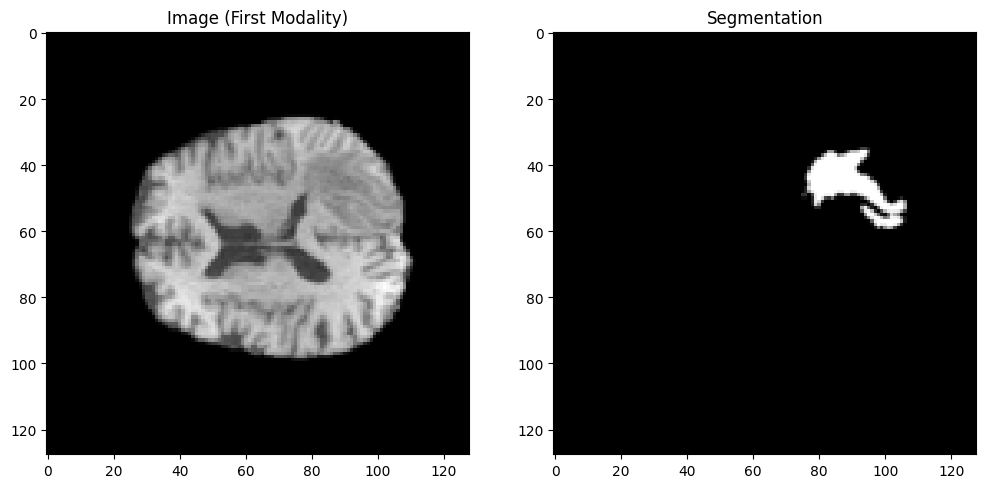

In [ ]:
# Get a sample from the dataset
sample_image, sample_segmentation = train_dataset[1]

# Convert the image and segmentation to numpy arrays for visualization
sample_image_np = sample_image[0]  # Visualize the first modality
sample_segmentation_np = sample_segmentation

# Select a specific slice for visualization
slice_index = 80  # You can change this index to visualize different slices
sample_image_slice = sample_image_np[slice_index]
sample_segmentation_slice = sample_segmentation_np[slice_index]

# Plot the image and its segmentation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_image_slice, cmap='gray')  # Visualize the selected slice
plt.title('Image (First Modality)')
plt.subplot(1, 2, 2)
plt.imshow(sample_segmentation_slice, cmap='gray')
plt.title('Segmentation')
plt.show()

In [ ]:
# Find the minimum, maximum, and average values for the image data
min_image_value = np.min(sample_image)
max_image_value = np.max(sample_image)
mean_image_value = np.mean(sample_image)

# Find the minimum, maximum, and a values for the segmentation data
min_segmentation_value = np.min(sample_segmentation.numpy())
max_segmentation_value = np.max(sample_segmentation.numpy())
mean_segmentation_value = np.mean(sample_segmentation.numpy())

print(f"Image Minimum: {min_image_value}, Image Maximum: {max_image_value}")
print(f"Segmentation Minimum: {min_segmentation_value}, Segmentation Maximum: {max_segmentation_value}")
print(f"Image Mean: {mean_image_value}, Segmentation Mean: {mean_segmentation_value}")

Image Minimum: 0.0, Image Maximum: 0.9416792988777161
Segmentation Minimum: 0.0, Segmentation Maximum: 1.0
Image Mean: 0.042993251234292984, Segmentation Mean: 0.011359368450939655


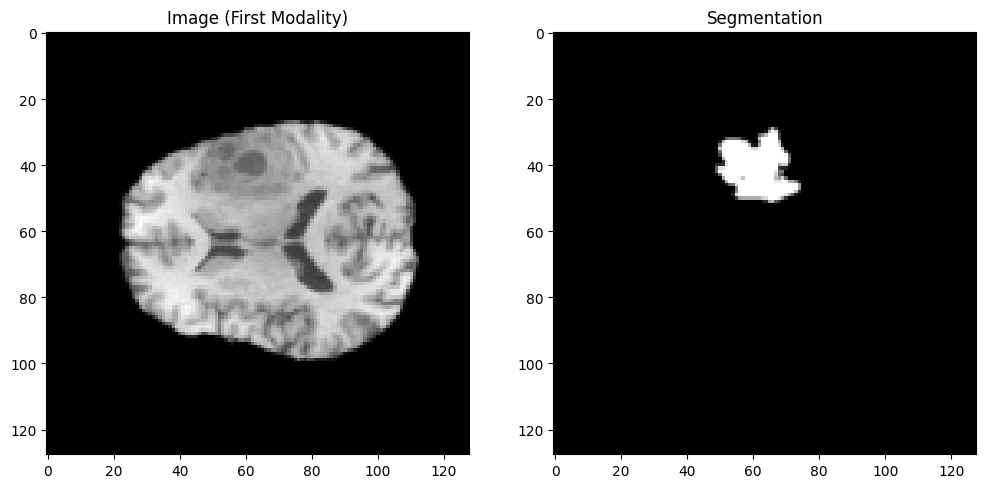

In [ ]:
# Get a batch of data from the train_loader
example_batch = next(iter(train_loader))
example_images, example_segmentations = example_batch

# Select the first image and its corresponding segmentation from the batch
example_image = example_images[0]
example_segmentation = example_segmentations[0]

# Convert the image and segmentation to numpy arrays for visualization
example_image_np = example_image[0].cpu().numpy()  # Visualize the first modality
example_segmentation_np = example_segmentation.cpu().numpy()

# Select a specific slice for visualization
slice_index = 80  # You can change this index to visualize different slices
example_image_slice = example_image_np[slice_index]
example_segmentation_slice = example_segmentation_np[slice_index]

# Plot the image and its segmentation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(example_image_slice, cmap='gray')  # Visualize the selected slice
plt.title('Image (First Modality)')
plt.subplot(1, 2, 2)
plt.imshow(example_segmentation_slice, cmap='gray')
plt.title('Segmentation')
plt.show()

### Splitting the Data

In [ ]:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
random.shuffle(indices)

train_split = int(0.8 * dataset_size)
test_split = int(0.9 * dataset_size)

train_indices = indices[:train_split]
test_indices = indices[train_split:test_split]
cv_indices = indices[test_split:]

# Create subsets using SubsetRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
cv_sampler = SubsetRandomSampler(cv_indices)

# Create data loaders for the subsets
train_loader = DataLoader(train_dataset, batch_size=1, sampler=train_sampler, pin_memory=True)
test_loader = DataLoader(train_dataset, batch_size=1, sampler=test_sampler, pin_memory=True)
cv_loader = DataLoader(train_dataset, batch_size=1, sampler=cv_sampler, pin_memory=True)

print("Training set size:", len(train_indices))
print("Testing set size:", len(test_indices))
print("Cross-validation set size:", len(cv_indices))

Training set size: 228
Testing set size: 28
Cross-validation set size: 29


## Model

In [ ]:
model_path_colab = '/content/models/brats_segmentation_model.pth'
os.makedirs(os.path.dirname(model_path_colab), exist_ok=True)  # Create directory if it doesn't exist

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)  # 4 input channels for 4 modalities
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()  # For binary segmentation
epochs = 20
cv_epochs = 4

scaler = GradScaler(enabled=True)

for epoch in range(epochs):
  model.train()
  for inputs, targets in tqdm(train_loader):
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()

      # Forward pass with mixed precision
      with autocast():
          outputs = model(inputs)
          loss = criterion(outputs, targets)

      # Backward pass with mixed precision (to prevent overloading GPU in use)
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      del inputs, targets, outputs
      torch.cuda.empty_cache()
  if epoch % cv_epochs == 0:
    model.eval()
    with torch.no_grad():
      cv_loss = 0
      for cv_inputs, cv_targets in cv_loader:
        cv_inputs, cv_targets = cv_inputs.to(device), cv_targets.to(device)
        cv_outputs = model(cv_inputs)
        cv_loss += criterion(cv_outputs, cv_targets).item()
      average_cv_loss = cv_loss / len(cv_loader)
      print(f"Cross-validation loss: {average_cv_loss}")
    torch.save(model.state_dict(), '/content/models/brats_segmentation_model_epoch_' + str(epoch) + '.pth')
    model.train()
  print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

<ipython-input-18-c18f0425b453>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=True)
  0%|          | 0/228 [00:00<?, ?it/s]<ipython-input-18-c18f0425b453>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 228/228 [09:02<00:00,  2.38s/it]


Cross-validation loss: 0.03348152326612637


100%|██████████| 228/228 [08:37<00:00,  2.27s/it]


Cross-validation loss: 0.02375591934883389


100%|██████████| 228/228 [08:38<00:00,  2.28s/it]


Cross-validation loss: 0.02640553884978952


100%|██████████| 228/228 [08:36<00:00,  2.27s/it]


Cross-validation loss: 0.02062624856701185


100%|██████████| 228/228 [08:16<00:00,  2.18s/it]


Cross-validation loss: 0.017955827125316036


100%|██████████| 228/228 [08:15<00:00,  2.18s/it]


In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    dice_scores = []
    hausdorff_distances = []
    sensitivities = []
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        # Apply a threshold to the outputs (e.g., 0.5) to get binary predictions
        predicted_segmentation = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        true_segmentation = targets.cpu().numpy()

        # Calculate metrics for each slice
        for i in range(predicted_segmentation.shape[0]):
          dice = dice_score(predicted_segmentation[i], true_segmentation[i])
          hd = hausdorff_distance(predicted_segmentation[i], true_segmentation[i])
          sens = sensitivity(predicted_segmentation[i], true_segmentation[i])
          dice_scores.append(dice)
          hausdorff_distances.append(hd)
          sensitivities.append(sens)


    print("Average Dice Score:", np.mean(dice_scores))
    print("Average Hausdorff Distance:", np.mean(hausdorff_distances))
    print("Average Sensitivity:", np.mean(sensitivities))

100%|██████████| 228/228 [11:16<00:00,  2.97s/it]

Average Dice Score: 0.6124212039944761
Average Hausdorff Distance: 22.73340414730071
Average Sensitivity: 0.5427804075824918


Save current model to google drive

In [ ]:
torch.save(model.state_dict(), model_path_colab)

# Save the model to Google Drive
model_path_drive = '/content/drive/MyDrive/models/brats_segmentation_model.pth'
os.makedirs(os.path.dirname(model_path_drive), exist_ok=True)  # Create directory if it doesn't exist
shutil.copyfile(model_path_colab, model_path_drive)

print(f"Model saved to {model_path_colab} (Colab) and {model_path_drive} (Google Drive)")

Model saved to /content/models/brats_segmentation_model.pth (Colab) and /content/drive/MyDrive/models/brats_segmentation_model.pth (Google Drive)


Save all models in models folder to google drive (redundant with last cell with current model)

In [ ]:
# Source directory in Colab
source_dir = "/content/models"

# Destination directory in Google Drive
destination_dir = "/content/drive/MyDrive/models"

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy the files
for filename in os.listdir(source_dir):
    source_path = os.path.join(source_dir, filename)
    destination_path = os.path.join(destination_dir, filename)

    # Check if it's a file before copying (prevents copying subdirectories if any)
    if os.path.isfile(source_path):
        shutil.copy2(source_path, destination_path)
        print(f"Copied {filename} to Google Drive")

In [ ]:
# Mount Google Drive (if not already mounted)
drive.mount('/content/drive', force_remount=True)

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

model_path_drive = '/content/drive/MyDrive/models/brats_segmentation_model.pth'

if os.path.exists(model_path_drive):
    model.load_state_dict(torch.load(model_path_drive, map_location=device, weights_only=False))
    print(f"Model loaded from {model_path_drive}")
    model.eval() #set to evaluation mode
else:
    print(f"Model not found at {model_path_drive}")

Mounted at /content/drive
Model loaded from /content/drive/MyDrive/models/brats_segmentation_model.pth


In [ ]:
def dice_score(pred, target):
    """
    Calculates the Dice score between predicted and target segmentations.
    """
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target)
    if union == 0:
        return 1.0  # Handle cases where both prediction and target are empty
    return 2 * intersection / union

def hausdorff_distance(pred, target):
    """
    Calculates the Hausdorff distance between predicted and target segmentations.
    """
    # Ensure predictions and targets are binary
    pred = np.where(pred > 0.5, 1, 0)
    target = np.where(target > 0.5, 1, 0)

    # Find coordinates of foreground pixels
    pred_coords = np.argwhere(pred)
    target_coords = np.argwhere(target)

    if pred_coords.size == 0 or target_coords.size == 0:
        return 0  # Handle cases where either prediction or target is empty

    return max(directed_hausdorff(pred_coords, target_coords)[0], directed_hausdorff(target_coords, pred_coords)[0])


def sensitivity(pred, target):
    """
    Calculates the sensitivity (recall) between predicted and target segmentations.
    """
    # Ensure predictions and targets are binary
    pred = np.where(pred > 0.5, 1, 0)
    target = np.where(target > 0.5, 1, 0)

    true_positives = np.sum(np.logical_and(pred == 1, target == 1))
    false_negatives = np.sum(np.logical_and(pred == 0, target == 1))

    if true_positives + false_negatives == 0:
      return 0
    return true_positives / (true_positives + false_negatives)

def maximum_mean_discrepancy(pred, target, kernel='rbf', gamma=1.0):
    """
    Calculates the Maximum Mean Discrepancy (MMD) between predicted and target distributions
    with reduced memory usage.

    Parameters:
        pred (np.ndarray): Predicted segmentation (flattened or 1D).
        target (np.ndarray): Target segmentation (flattened or 1D).
        kernel (str): Kernel type ('rbf' supported).
        gamma (float): Gamma parameter for the RBF kernel.

    Returns:
        float: The MMD value.
    """
    pred = pred.flatten().astype(np.float32)  # Convert to float32
    target = target.flatten().astype(np.float32)  # Convert to float32

    if kernel == 'rbf':
        # Calculate squared Euclidean distances using broadcasting
        pred_sq_dist = np.sum((pred[:, np.newaxis] - pred)**2, axis=-1)
        target_sq_dist = np.sum((target[:, np.newaxis] - target)**2, axis=-1)
        cross_sq_dist = np.sum((pred[:, np.newaxis] - target)**2, axis=-1)

        # RBF kernel computation
        k_pred = np.exp(-gamma * pred_sq_dist)
        k_target = np.exp(-gamma * target_sq_dist)
        k_cross = np.exp(-gamma * cross_sq_dist)

        # MMD calculation
        mmd = np.mean(k_pred) + np.mean(k_target) - 2 * np.mean(k_cross)
        return mmd
    else:
        raise ValueError(f"Unsupported kernel type: {kernel}")

In [ ]:
num_predictions = 10

model.eval()
dice_scores = []
hausdorff_distances = []
sensitivities = []
criterion = nn.BCEWithLogitsLoss()
losses = []
with torch.no_grad():
  i = 1
  for inputs, targets in tqdm(test_loader):
    inputs, targets = inputs.to(device), targets.to(device)

    # Initialize lists to store predictions for each image
    image_dice_scores = []
    image_hausdorff_distances = []
    image_sensitivities = []
    image_losses = []

    for _ in range(num_predictions):
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        image_losses.append(loss.item())

        predicted_segmentation = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        true_segmentation = targets.cpu().numpy()

        dice = dice_score(predicted_segmentation, true_segmentation)
        distance = hausdorff_distance(predicted_segmentation, true_segmentation)
        sens = sensitivity(predicted_segmentation, true_segmentation)

        image_dice_scores.append(dice)
        image_hausdorff_distances.append(distance)
        image_sensitivities.append(sens)

    avg_dice = np.mean(image_dice_scores)
    avg_hausdorff = np.mean(image_hausdorff_distances)
    avg_sensitivity = np.mean(image_sensitivities)
    avg_loss = np.mean(image_losses)

    print(f"Dice score on image {i}: {avg_dice}")
    print(f"Hausdorff distance on image {i}: {avg_hausdorff}")
    print(f"Sensitivity on image {i}: {avg_sensitivity}")
    print(f"Loss on image {i}: {avg_loss}")

    # Append average metric across predictions for this image
    dice_scores.append(avg_dice)
    hausdorff_distances.append(avg_hausdorff)
    sensitivities.append(avg_sensitivity)
    losses.append(avg_loss)
    i += 1

# Calculate and print the average metrics across all images
avg_dice = np.mean(dice_scores)
avg_hausdorff = np.mean(hausdorff_distances)
avg_sensitivity = np.mean(sensitivities)
avg_loss = np.mean(losses)

print(f"Average Dice Score: {avg_dice}")
print(f"Average Hausdorff Distance: {avg_hausdorff}")
print(f"Average Sensitivity: {avg_sensitivity}")
print(f"Average Loss: {avg_loss}")

  4%|▎         | 1/28 [00:16<07:30, 16.68s/it]

Dice score on image 1: 0.8539210650599426
Hausdorff distance on image 1: 16.492422502470642
Sensitivity on image 1: 0.8162813964509505
Loss on image 1: 0.005814341362565756


  7%|▋         | 2/28 [00:33<07:10, 16.56s/it]

Dice score on image 2: 0.725889095124252
Hausdorff distance on image 2: 14.45683229480096
Sensitivity on image 2: 0.6289382287273629
Loss on image 2: 0.03100155107676983


 11%|█         | 3/28 [00:48<06:40, 16.04s/it]

Dice score on image 3: 0.7785880382668253
Hausdorff distance on image 3: 12.083045973594574
Sensitivity on image 3: 0.7297784374006149
Loss on image 3: 0.0077334679663181305


 14%|█▍        | 4/28 [01:04<06:22, 15.96s/it]

Dice score on image 4: 0.7972384154044826
Hausdorff distance on image 4: 10.246950765959598
Sensitivity on image 4: 0.6812947976878612
Loss on image 4: 0.007526347413659096


 18%|█▊        | 5/28 [01:21<06:12, 16.21s/it]

Dice score on image 5: 0.469804111568959
Hausdorff distance on image 5: 11.832159566199234
Sensitivity on image 5: 0.3105855855855856
Loss on image 5: 0.006886754184961319


 21%|██▏       | 6/28 [01:36<05:49, 15.90s/it]

Dice score on image 6: 0.3508219097606849
Hausdorff distance on image 6: 54.359911699707524
Sensitivity on image 6: 0.2307875327147276
Loss on image 6: 0.0035147371236234903


 25%|██▌       | 7/28 [01:51<05:31, 15.80s/it]

Dice score on image 7: 0.5533699592033079
Hausdorff distance on image 7: 11.575836902790225
Sensitivity on image 7: 0.39695664257921065
Loss on image 7: 0.012629332020878792


 29%|██▊       | 8/28 [02:07<05:12, 15.65s/it]

Dice score on image 8: 0.7805618697763597
Hausdorff distance on image 8: 26.72077843177477
Sensitivity on image 8: 0.7050380785002928
Loss on image 8: 0.006632169708609581


 32%|███▏      | 9/28 [02:22<04:57, 15.66s/it]

Dice score on image 9: 0.4974266064555673
Hausdorff distance on image 9: 13.638181696985857
Sensitivity on image 9: 0.33767114839028
Loss on image 9: 0.013686616905033588


 36%|███▌      | 10/28 [02:38<04:38, 15.50s/it]

Dice score on image 10: 0.3921385247294255
Hausdorff distance on image 10: 22.93468988235943
Sensitivity on image 10: 0.29084366253498606
Loss on image 10: 0.02212243527173996


 39%|███▉      | 11/28 [02:53<04:22, 15.44s/it]

Dice score on image 11: 0.8812142312585717
Hausdorff distance on image 11: 30.0
Sensitivity on image 11: 0.9657280530040657
Loss on image 11: 0.011706924997270107


 43%|████▎     | 12/28 [03:09<04:08, 15.52s/it]

Dice score on image 12: 0.7913122486380342
Hausdorff distance on image 12: 35.05709628591621
Sensitivity on image 12: 0.8685946659168092
Loss on image 12: 0.02085712179541588


 46%|████▋     | 13/28 [03:25<03:54, 15.64s/it]

Dice score on image 13: 0.4836984274835813
Hausdorff distance on image 13: 10.63014581273465
Sensitivity on image 13: 0.3251421412739713
Loss on image 13: 0.006936746183782816


 50%|█████     | 14/28 [04:06<05:29, 23.52s/it]

Dice score on image 14: 0.6371036573841662
Hausdorff distance on image 14: 10.816653826391969
Sensitivity on image 14: 0.46911664433001815
Loss on image 14: 0.025294272229075432


 54%|█████▎    | 15/28 [04:22<04:34, 21.15s/it]

Dice score on image 15: 0.015574923232853654
Hausdorff distance on image 15: 40.90232267243512
Sensitivity on image 15: 0.009450679267572357
Loss on image 15: 0.012855096720159054


 57%|█████▋    | 16/28 [04:44<04:17, 21.43s/it]

Dice score on image 16: 0.7581170738398998
Hausdorff distance on image 16: 18.2208671582886
Sensitivity on image 16: 0.6234647807280649
Loss on image 16: 0.013761566020548344


 61%|██████    | 17/28 [04:59<03:34, 19.51s/it]

Dice score on image 17: 0.312095698724015
Hausdorff distance on image 17: 18.138357147217054
Sensitivity on image 17: 0.20017198547678197
Loss on image 17: 0.009252228774130344


 64%|██████▍   | 18/28 [05:15<03:04, 18.48s/it]

Dice score on image 18: 0.6149358698956837
Hausdorff distance on image 18: 19.1049731745428
Sensitivity on image 18: 0.46052209608107236
Loss on image 18: 0.009579838253557682


 68%|██████▊   | 19/28 [05:33<02:43, 18.16s/it]

Dice score on image 19: 0.7206632545038556
Hausdorff distance on image 19: 12.529964086141666
Sensitivity on image 19: 0.583606395821528
Loss on image 19: 0.020441602915525436


 71%|███████▏  | 20/28 [05:59<02:44, 20.57s/it]

Dice score on image 20: 0.6280832840622395
Hausdorff distance on image 20: 17.944358444926362
Sensitivity on image 20: 0.46794894090640327
Loss on image 20: 0.02296394482254982


 75%|███████▌  | 21/28 [06:16<02:16, 19.44s/it]

Dice score on image 21: 0.9323451535896468
Hausdorff distance on image 21: 3.0
Sensitivity on image 21: 0.9515966657270566
Loss on image 21: 0.0046163154765963554


 79%|███████▊  | 22/28 [06:32<01:51, 18.51s/it]

Dice score on image 22: 0.8549549117119681
Hausdorff distance on image 22: 16.43167672515498
Sensitivity on image 22: 0.9542916583806275
Loss on image 22: 0.02234617806971073


 82%|████████▏ | 23/28 [06:48<01:28, 17.76s/it]

Dice score on image 23: 0.7263285988924075
Hausdorff distance on image 23: 37.8549864614954
Sensitivity on image 23: 0.9676958261863924
Loss on image 23: 0.023591795936226845


 86%|████████▌ | 24/28 [07:10<01:15, 18.92s/it]

Dice score on image 24: 0.38441674833038164
Hausdorff distance on image 24: 26.19160170741759
Sensitivity on image 24: 0.23902662392882842
Loss on image 24: 0.03053300827741623


 89%|████████▉ | 25/28 [08:14<01:37, 32.51s/it]

Dice score on image 25: 0.7913207486990104
Hausdorff distance on image 25: 17.74823934929885
Sensitivity on image 25: 0.6582640332640333
Loss on image 25: 0.021471183747053146


 93%|█████████▎| 26/28 [08:31<00:55, 27.82s/it]

Dice score on image 26: 0.895987651542977
Hausdorff distance on image 26: 15.297058540778355
Sensitivity on image 26: 0.969527402954531
Loss on image 26: 0.007874934934079647


 96%|█████████▋| 27/28 [08:46<00:24, 24.17s/it]

Dice score on image 27: 0.0
Hausdorff distance on image 27: 0.0
Sensitivity on image 27: 0.0
Loss on image 27: 0.013033165596425533


100%|██████████| 28/28 [09:02<00:00, 19.39s/it]

Dice score on image 28: 0.21537413409332026
Hausdorff distance on image 28: 13.964240043768942
Sensitivity on image 28: 0.12200137080191913
Loss on image 28: 0.006403839681297541
Average Dice Score: 0.6015459361154436
Average Hausdorff Distance: 19.220476826898267
Average Sensitivity: 0.5344401955221982


Average Dice Score: 0.6015459361154436
Average Hausdorff Distance: 19.220476826898267
Average Sensitivity: 0.5344401955221982
Average Loss: 0.01432383990946359


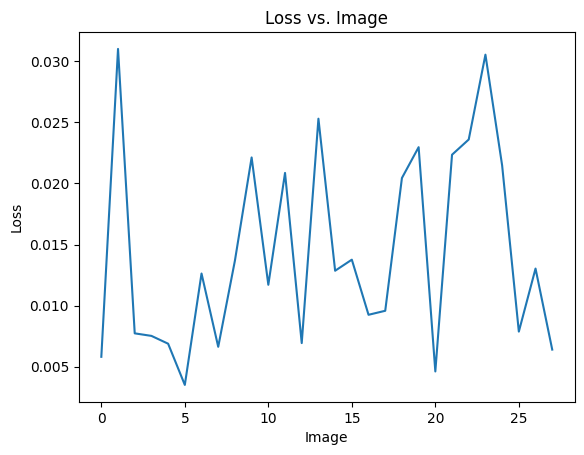

In [ ]:
# Calculate and print the average metrics across all images
avg_dice = np.mean(dice_scores)
avg_hausdorff = np.mean(hausdorff_distances)
avg_sensitivity = np.mean(sensitivities)
avg_loss = np.mean(losses)

print(f"Average Dice Score: {avg_dice}")
print(f"Average Hausdorff Distance: {avg_hausdorff}")
print(f"Average Sensitivity: {avg_sensitivity}")
print(f"Average Loss: {avg_loss}")

plt.plot(losses)
plt.xlabel('Image')
plt.ylabel('Loss')
plt.title('Loss vs. Image')
plt.show()

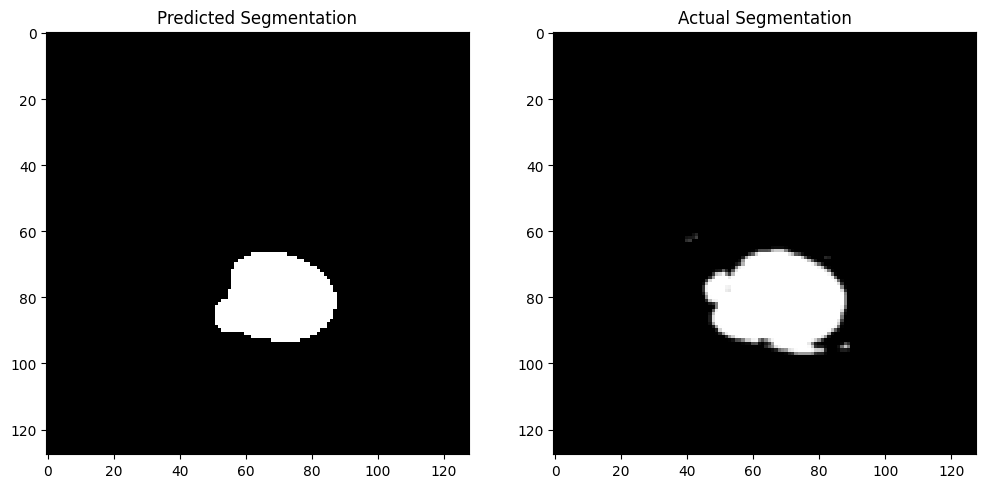

Dice score for the current image: 0.7913207486990104
Hausdorff distance for the current image: 17.74823934929885
Sensitivity (Recall) for the current image: 0.6582640332640333


In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        # Apply a threshold to the model's output to get binary predictions
        threshold = 0.5  # You might need to adjust this threshold
        predicted_segmentation = (torch.sigmoid(outputs) > threshold).cpu().numpy()

        # Convert the target segmentation to a numpy array
        true_segmentation = targets.cpu().numpy()

        # Select a specific slice for visualization
        slice_index = 80  # You can change this index to visualize different slices
        predicted_segmentation_slice = predicted_segmentation[0, slice_index]
        true_segmentation_slice = true_segmentation[0, slice_index]

        # Plot the predicted and actual segmentations
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(predicted_segmentation_slice, cmap='gray')
        plt.title('Predicted Segmentation')
        plt.subplot(1, 2, 2)
        plt.imshow(true_segmentation_slice, cmap='gray')
        plt.title('Actual Segmentation')
        plt.show()

        # Calculate the Dice score
        score = dice_score(predicted_segmentation, true_segmentation)
        print(f"Dice score for the current image: {score}")

        # Calculate the Hausdorff distance
        hd = hausdorff_distance(predicted_segmentation, true_segmentation)
        print(f"Hausdorff distance for the current image: {hd}")

        # Calculate the sensitivity (recall)
        sensitivity_score = sensitivity(predicted_segmentation, true_segmentation)
        print(f"Sensitivity (Recall) for the current image: {sensitivity_score}")

        # Exit the loop after processing one image
        break

In [ ]:
model.load_state_dict(torch.load(model_path_colab, map_location=device, weights_only=False)) # used for when the model on google drive does not load properly

<All keys matched successfully>

In [ ]:
def monte_carlo_uncertainty(model, images, num_samples=10):
  model.train()  # Keep dropout active
  preds = torch.stack([torch.sigmoid(model(images)) for _ in tqdm(range(num_samples))])
  mean_pred = preds.mean(dim=0)
  uncertainty = preds.var(dim=0)
  return mean_pred, uncertainty

100%|██████████| 10/10 [00:01<00:00,  5.27it/s]


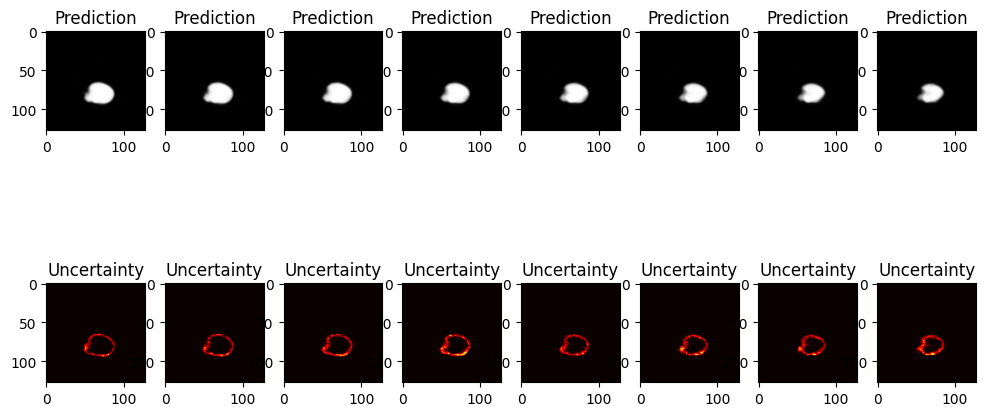

In [ ]:
# Visualize uncertainty
import matplotlib.pyplot as plt

model.train() # turn on dropout layers
with torch.no_grad():
  mean_pred, uncertainty = monte_carlo_uncertainty(model, inputs)
  plt.figure(figsize=(12, 6))
  for i in range(8):
      plt.subplot(2, 8, i+1)
      plt.imshow(mean_pred[0, i + 80].cpu(), cmap='gray')
      plt.title('Prediction')
      plt.subplot(2, 8, i+9)
      plt.imshow(uncertainty[0, i + 80].cpu(), cmap='hot')
      plt.title('Uncertainty')
  plt.show()

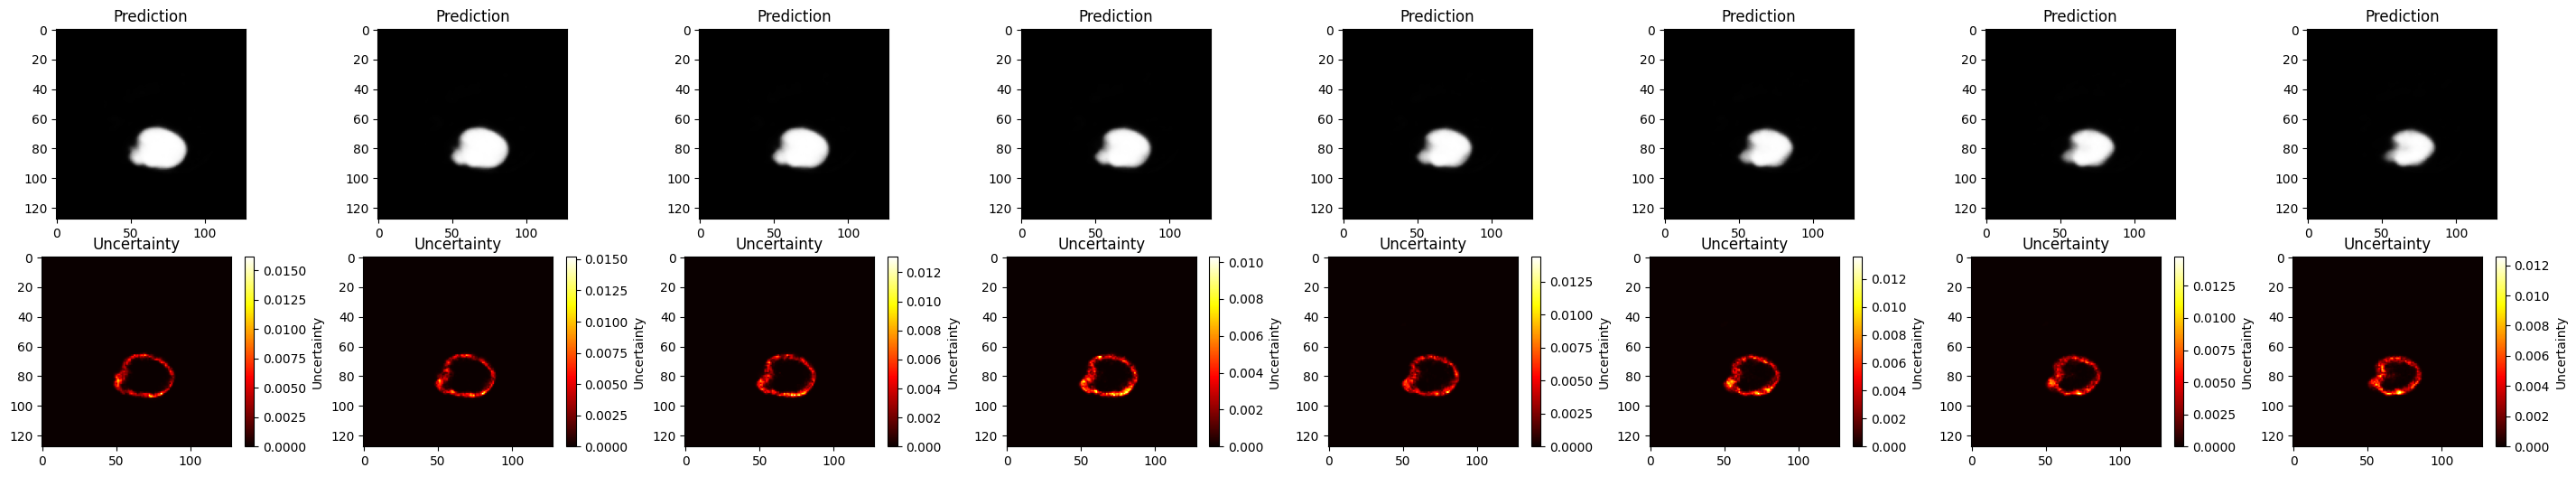

In [ ]:
# Visualize uncertainty
import matplotlib.pyplot as plt

plt.figure(figsize=(36, 6))

num_slices_to_visualize = min(8, mean_pred.shape[1])

for i in range(num_slices_to_visualize):
    plt.subplot(2, num_slices_to_visualize, i+1)
    plt.imshow(mean_pred[0, 80 + i].cpu(), cmap='gray')
    plt.title('Prediction')
    plt.subplot(2, num_slices_to_visualize, i+1 + num_slices_to_visualize)
    plt.imshow(uncertainty[0, 80 + i].cpu(), cmap='hot')
    plt.colorbar(label='Uncertainty')
    plt.title('Uncertainty')
plt.show()


In [ ]:
def plot_prob_gt_probability_distribution(predictions, ground_truth, num_samples=128*128):
    """
    Plots the probability distribution of predicted pixels that overlap with the ground truth (one prediction).

    Args:
        predictions: Predicted segmentation (numpy array).
        ground_truth: Ground truth segmentation (numpy array).
        num_samples: The number of random samples to take from the ground truth.
    """

    # Find overlapping pixels
    overlapping_indices = np.where(ground_truth > 0.5)

    # Randomly select a subset of overlapping indices
    num_overlapping_pixels = len(overlapping_indices[0])
    selected_indices = np.random.choice(num_overlapping_pixels, min(num_samples, num_overlapping_pixels), replace=False)

    # Convert boolean predictions to numerical values (0 or 1) before sampling
    predictions = predictions.astype(np.float32)

    sampled_probabilities = predictions[overlapping_indices[0][selected_indices], overlapping_indices[1][selected_indices]]

    # Create a histogram of sampled probabilities using sns.displot
    sns.displot(sampled_probabilities, kde=True)  # Use sns.displot instead of plt.hist
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Probability Distribution of Overlapping Predicted Pixels')
    plt.show()

predictions = torch.sigmoid(outputs).cpu().numpy()[0 ,slice_index]
ground_truth = true_segmentation_slice

plot_probability_distribution(predictions, ground_truth)

100%|██████████| 100/100 [02:23<00:00,  1.43s/it]


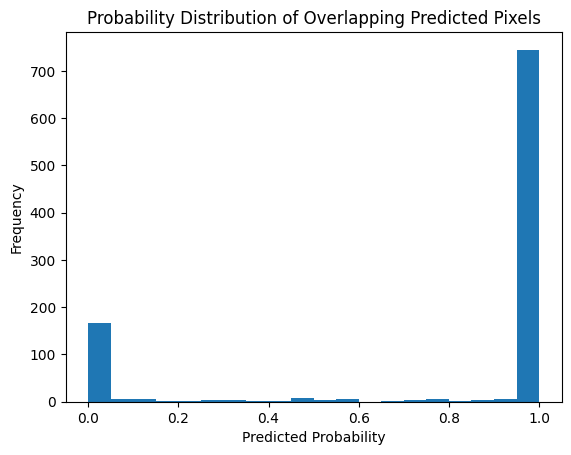

In [ ]:
def plot_pred_gt_probability_distribution(ground_truth, num_predictions=100):
    """
    Plots the probability distribution of predicted pixels that overlap with the ground truth (multiple predictions).
    """
    model.train()
    # Find overlapping pixels
    overlapping_indices = np.where(ground_truth > 0.5)

    sampled_probabilities = []
    for _ in tqdm(range(num_predictions)):
        with torch.no_grad():
            outputs = model(inputs)
            probabilities = (torch.sigmoid(outputs) > 0.5).cpu().numpy()[0, slice_index]
            # Extract probabilities for overlapping pixels
            sampled_probabilities.append(probabilities[overlapping_indices])

    sampled_probabilities = np.mean(sampled_probabilities, axis=0)
    plt.hist(sampled_probabilities, bins=20)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Probability Distribution of Overlapping Predicted Pixels')
    plt.show()

plot_probability_distribution(true_segmentation_slice)